<a href="https://colab.research.google.com/github/santoshyfs/Portfolio/blob/master/EDA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Step 1 :  Load required libraries

In [59]:
# Basic setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plots
sns.set(style="whitegrid", palette="pastel")
plt.rcParams['figure.figsize'] = (10, 5)

#Load data

In [60]:
# Example dataset:
from google.colab import drive
#drive.mount('/content/drive')

#!ls /content/drive/MyDrive/
data = pd.read_csv('/content/drive/MyDrive/sales_data.csv')

# Preview
data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,INV1072,DRESS004,Women's Summer Dress,3,3/29/2024,49.99,10073.0,Australia
1,INV1182,SKIRT009,Pleated Skirt,4,6/1/2024,34.99,10028.0,USA
2,INV1085,TSHIRT001,Men's Cotton T-Shirt,5,3/31/2024,15.99,10000.0,Canada
3,INV1114,BAG005,Handcrafted Tote Bag,1,3/4/2024,29.99,10083.0,Canada
4,INV1075,TSHIRT001,Men's Cotton T-Shirt,5,1/26/2024,15.99,10086.0,India


In [61]:
#Describe
data.describe()


,Quantity,UnitPrice,CustomerID
count,502.000000,502.000000,500.000000
mean,2.966135,36.768884,10050.688000
std,1.422954,20.279999,28.700978
min,0.000000,12.990000,10000.000000
25%,2.000000,19.990000,10026.000000
50%,3.000000,29.990000,10050.500000
75%,4.000000,49.990000,10076.000000
max,5.000000,79.990000,10100.000000


In [62]:
# Remove missing customer IDs
data = data.dropna(subset=['CustomerID'])

# Remove cancellations or refunds (negative quantities)
data = data[data['Quantity'] > 0]

# Create TotalPrice column
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Preview clean data
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 501
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    500 non-null    object        
 1   StockCode    500 non-null    object        
 2   Description  500 non-null    object        
 3   Quantity     500 non-null    int64         
 4   InvoiceDate  500 non-null    datetime64[ns]
 5   UnitPrice    500 non-null    float64       
 6   CustomerID   500 non-null    float64       
 7   Country      500 non-null    object        
 8   TotalPrice   500 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 39.1+ KB


In [63]:
total_sales = data['TotalPrice'].sum()
print(f"Total Sales: ${total_sales:.2f}")

Total Sales: $53531.16


In [64]:
product_sales = data.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False)
print("Total Sales by Product:")
display(product_sales)

Total Sales by Product:


,TotalPrice
Description,
Winter Jacket,11838.52
Leather Casual Shoes,8518.58
Women's Summer Dress,5748.85
Blue Denim Jeans,5518.62
Handcrafted Tote Bag,5488.17
Pleated Skirt,5353.47
Silk Scarf,3623.55
Men's Cotton T-Shirt,2926.17
Leather Belt,2618.69


In [65]:
country_sales = data.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
print("Total Sales by Country:")
display(country_sales)

Total Sales by Country:


,TotalPrice
Country,
USA,12017.66
UK,11694.80
Canada,10794.97
India,9734.13
Australia,9289.60


/tmp/ipython-input-1043541501.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_sales.index, y=country_sales.values, palette="viridis")


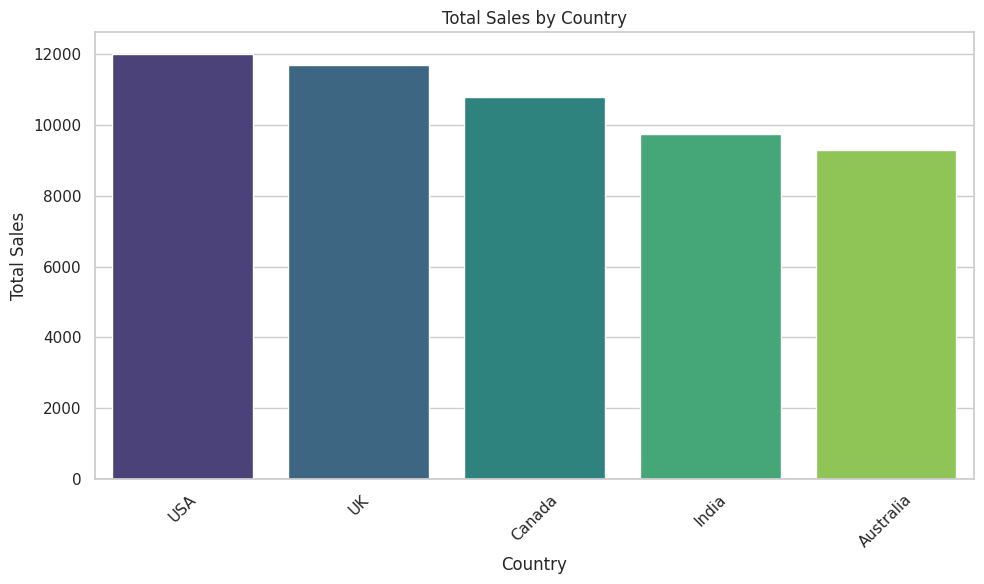

In [66]:


plt.figure(figsize=(10, 6))
sns.barplot(x=country_sales.index, y=country_sales.values, palette="viridis")
plt.title('Total Sales by Country')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [67]:
# Define a reference date (e.g., last date in dataset)
reference_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)
data['TotalAmount'] = data['Quantity'] * data['UnitPrice']


# Aggregate by CustomerID
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalAmount': 'sum'                                       # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm.head()


# Score each metric
rfm['R_rank'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_rank'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_rank'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

# Combine into one RFM score
rfm['RFM_Score'] = rfm['R_rank'].astype(str) + rfm['F_rank'].astype(str) + rfm['M_rank'].astype(str)
rfm.head()



,CustomerID,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,RFM_Score
0,10000.0,17,7,904.74,4,5,5,455
1,10001.0,14,3,339.91,4,1,2,412
2,10002.0,81,5,555.85,2,3,3,233
3,10003.0,12,3,110.95,5,1,1,511
4,10004.0,58,1,79.95,2,1,1,211


In [68]:
# Sort by overall RFM Score
top_customers = rfm.sort_values(by=['R_rank','F_rank','M_rank'], ascending=[False, False, False])

print("Top 10% customers:")
top_10_percent = top_customers.head(int(len(top_customers) * 0.1))
top_10_percent


Top 10% customers:


,CustomerID,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,RFM_Score
72,10073.0,100,7,968.82,1,5,5,155
78,10079.0,119,7,644.80,1,5,4,154
90,10091.0,195,7,613.80,1,5,4,154
31,10032.0,142,5,397.87,1,3,3,133
97,10098.0,125,4,316.89,1,3,2,132
67,10068.0,99,4,599.86,1,2,4,124
27,10028.0,127,4,339.87,1,2,2,122
66,10067.0,100,4,379.91,1,2,2,122
81,10082.0,101,3,289.87,1,2,2,122
85,10086.0,143,3,151.92,1,2,1,121


In [69]:
total_revenue = rfm['Monetary'].sum()
top_revenue = top_10_percent['Monetary'].sum()
percentage = (top_revenue / total_revenue) * 100

print(f"Top 10% customers contribute {percentage:.2f}% of total revenue.")


Top 10% customers contribute 8.79% of total revenue.


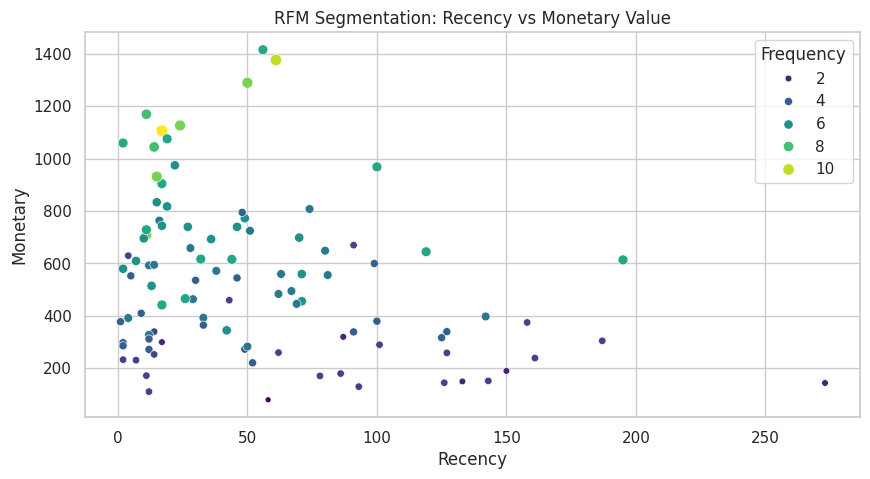

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', size='Frequency', hue='Frequency', palette='viridis')
plt.title("RFM Segmentation: Recency vs Monetary Value")
plt.show()


In [71]:
# Score each metric
rfm['R_rank'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_rank'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_rank'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

# Combine into one RFM score
rfm['RFM_Score'] = rfm['R_rank'].astype(str) + rfm['F_rank'].astype(str) + rfm['M_rank'].astype(str)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,RFM_Score
0,10000.0,17,7,904.74,4,5,5,455
1,10001.0,14,3,339.91,4,1,2,412
2,10002.0,81,5,555.85,2,3,3,233
3,10003.0,12,3,110.95,5,1,1,511
4,10004.0,58,1,79.95,2,1,1,211


In [77]:
# Convert ranking columns to integers (for sorting)
rfm['R_rank'] = rfm['R_rank'].astype(int)
rfm['F_rank'] = rfm['F_rank'].astype(int)
rfm['M_rank'] = rfm['M_rank'].astype(int)


def rfm_segment(row):
    if row['R_rank'] >= 4 and row['F_rank'] >= 4:
        return 'Champions'
    elif row['R_rank'] >= 3 and row['F_rank'] >= 3:
        return 'Loyal'
    elif row['R_rank'] <= 2 and row['F_rank'] >= 4:
        return 'At Risk'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(rfm_segment, axis=1)
rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean()


,Recency,Frequency,Monetary
Segment,,,
At Risk,90.777778,6.777778,838.006667
Champions,14.428571,7.095238,815.785714
Loyal,29.666667,5.428571,562.223810
Others,74.918367,3.489796,347.977551


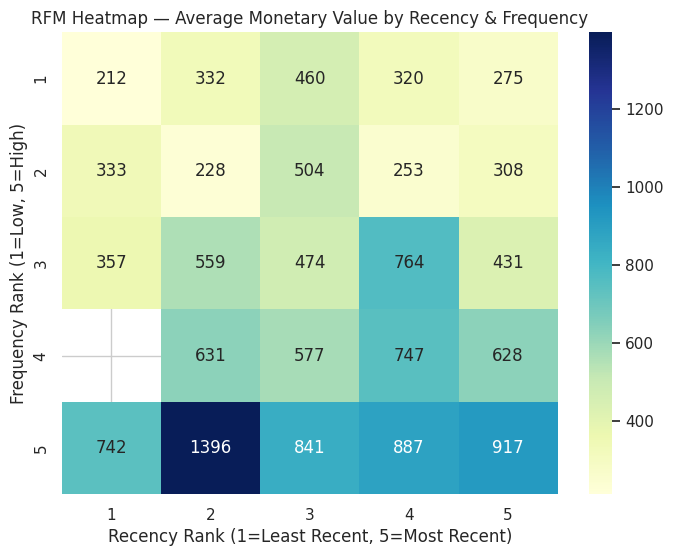

In [75]:
plt.figure(figsize=(8,6))
sns.heatmap(rfm_pivot, cmap='YlGnBu', annot=True, fmt=".0f")
plt.title('RFM Heatmap — Average Monetary Value by Recency & Frequency')
plt.xlabel('Recency Rank (1=Least Recent, 5=Most Recent)')
plt.ylabel('Frequency Rank (1=Low, 5=High)')
plt.show()
